In [2]:
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Criando o modelo 




Epoch 1/10


262/263 [============================>.] - ETA: 0s - loss: 0.4350 - accuracy: 0.8636
Epoch 1: val_accuracy improved from -inf to 0.96988, saving model to best_weights.h5
263/263 [==============================] - 3s 10ms/step - loss: 0.4343 - accuracy: 0.8639 - val_loss: 0.1008 - val_accuracy: 0.9699
Epoch 2/10
 14/263 [>.............................] - ETA: 2s - loss: 0.1637 - accuracy: 0.9498

c:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


260/263 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9599
Epoch 2: val_accuracy improved from 0.96988 to 0.97881, saving model to best_weights.h5
263/263 [==============================] - 2s 9ms/step - loss: 0.1347 - accuracy: 0.9601 - val_loss: 0.0649 - val_accuracy: 0.9788
Epoch 3/10
262/263 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9704
Epoch 3: val_accuracy improved from 0.97881 to 0.98464, saving model to best_weights.h5
263/263 [==============================] - 2s 9ms/step - loss: 0.0987 - accuracy: 0.9704 - val_loss: 0.0500 - val_accuracy: 0.9846
Epoch 4/10
263/263 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9764
Epoch 4: val_accuracy improved from 0.98464 to 0.98655, saving model to best_weights.h5
263/263 [==============================] - 2s 9ms/step - loss: 0.0785 - accuracy: 0.9764 - val_loss: 0.0432 - val_accuracy: 0.9865
Epoch 5/10
259/263 [============================>.] - ETA: 0s - lo

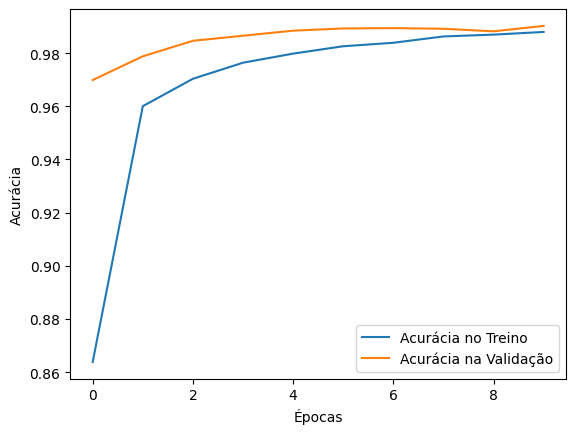

875/875 [==============================] - 1s 1ms/step
Arquivo de submissão 'submission.csv' criado com sucesso!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Passo 1: Carregar os dados dos arquivos CSV
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Separar features (X) e labels (y) no conjunto de treino
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values

# Conjunto de teste (não tem labels)
X_test = test_data.values

# Normalizar os dados (escala de 0 a 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape dos dados para o formato (28, 28, 1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Converter labels para one-hot encoding
y_train = to_categorical(y_train, num_classes=10)

# Passo 2: Construção do Modelo CNN
model = Sequential()

# Primeira camada convolucional
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda camada convolucional
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Camada de Flatten para converter a matriz 2D em um vetor 1D
model.add(Flatten())

# Camada totalmente conectada
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Camada de saída
model.add(Dense(10, activation='softmax'))

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Passo 3: Callback para salvar os melhores pesos
checkpoint = ModelCheckpoint(
    'best_weights.h5',  # Nome do arquivo onde os pesos serão salvos
    monitor='val_accuracy',  # Métrica a ser monitorada (acurácia de validação)
    save_best_only=True,  # Salvar apenas o melhor modelo
    mode='max',  # Modo 'max' porque queremos maximizar a acurácia
    verbose=1  # Mostrar mensagens durante o treinamento
)

# Passo 4: Treinamento do Modelo com o Callback
history = model.fit(
    X_train, y_train,
    epochs=10,  # Número de épocas
    batch_size=128,  # Tamanho do batch
    validation_split=0.2,  # 20% dos dados de treino serão usados para validação
    callbacks=[checkpoint]  # Adiciona o callback ao treinamento
)

# Passo 5: Avaliação do Modelo
plt.plot(history.history['accuracy'], label='Acurácia no Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Passo 6: Predição no Conjunto de Teste
# Carregar os melhores pesos salvos
model.load_weights('best_weights.h5')

# Fazer predições
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Passo 7: Preparar o Arquivo de Submissão para o Kaggle
submission = pd.DataFrame({'ImageId': range(1, len(predicted_labels) + 1), 'Label': predicted_labels})
submission.to_csv('submission.csv', index=False)

print("Arquivo de submissão 'submission.csv' criado com sucesso!")

In [4]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [5]:
import pandas as pd

# Carregar o arquivo test.csv
test_data = pd.read_csv('test.csv')

# Selecionar as primeiras N linhas (por exemplo, N = 10)
N = 10
new_data = test_data.head(N)

# Salvar como new_data.csv
new_data.to_csv('new_data.csv', index=False)

print(f"Arquivo 'new_data.csv' criado com as primeiras {N} linhas do 'test.csv'.")

Arquivo 'new_data.csv' criado com as primeiras 10 linhas do 'test.csv'.


In [6]:
# Carregar os novos dados
new_data = pd.read_csv('new_data.csv')

# Normalizar os dados (escala de 0 a 1)
new_data = new_data / 255.0

# Reshape dos dados para o formato (28, 28, 1)
new_data = new_data.values.reshape(-1, 28, 28, 1)

In [7]:
# Fazer a predição
predictions = model.predict(new_data)

# Converter as predições em labels (classes)
predicted_labels = np.argmax(predictions, axis=1)

# Exibir as predições
print("Labels preditos:", predicted_labels)

1/1 [==============================] - 0s 40ms/step
Labels preditos: [2 0 9 9 3 7 0 3 0 3]


1/1 [==============================] - 0s 40ms/step
Visualizando ativações da camada: conv2d_1
Formato da ativação: (1, 26, 26, 32)


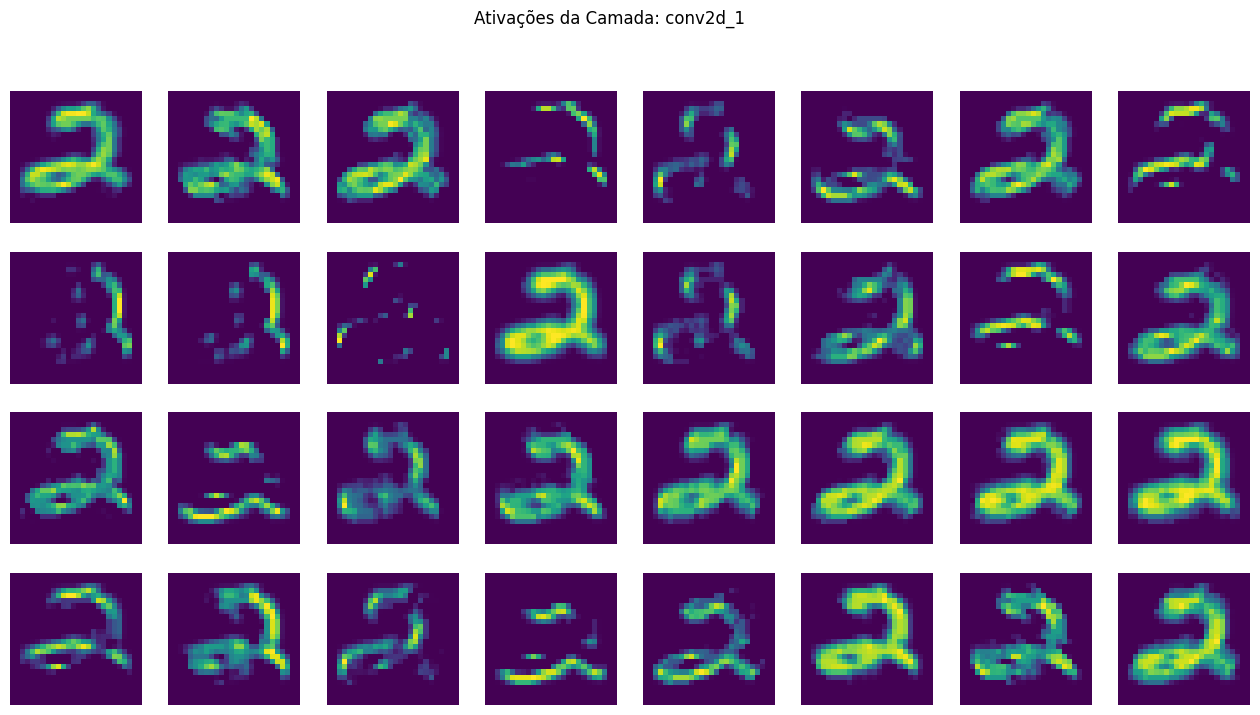

Visualizando ativações da camada: maxpooling2d_1
Formato da ativação: (1, 13, 13, 32)


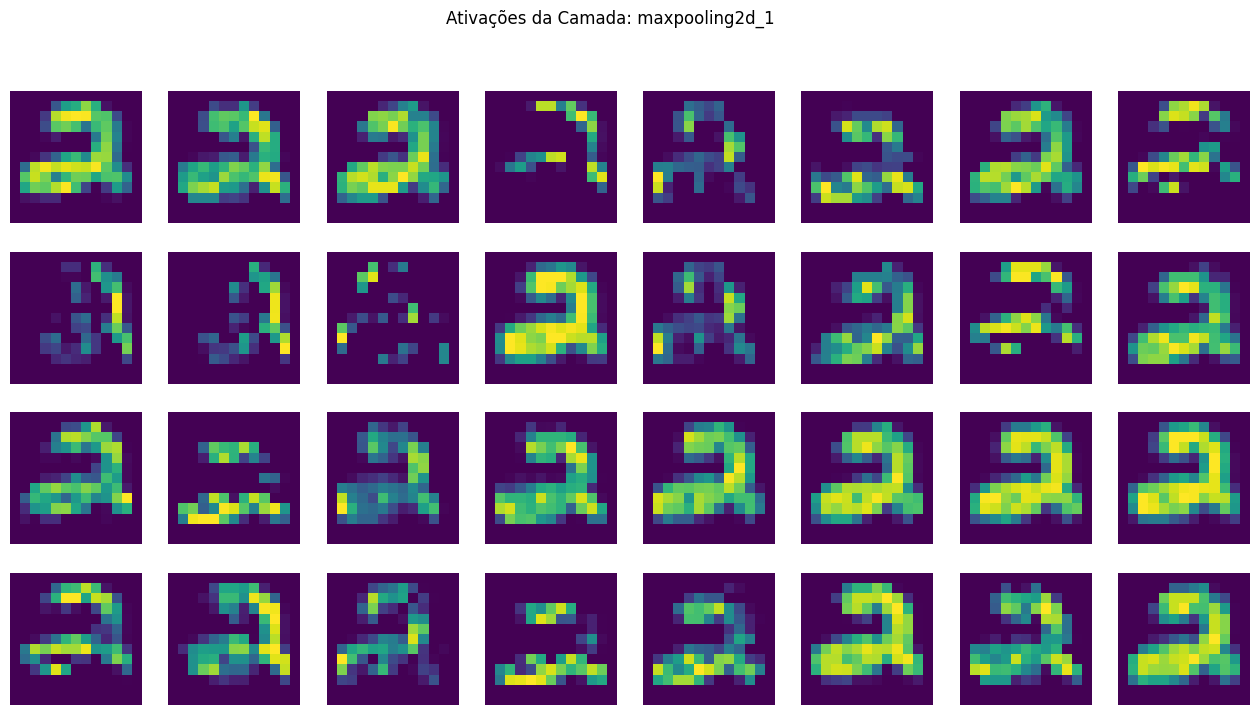

Visualizando ativações da camada: conv2d_2
Formato da ativação: (1, 11, 11, 64)


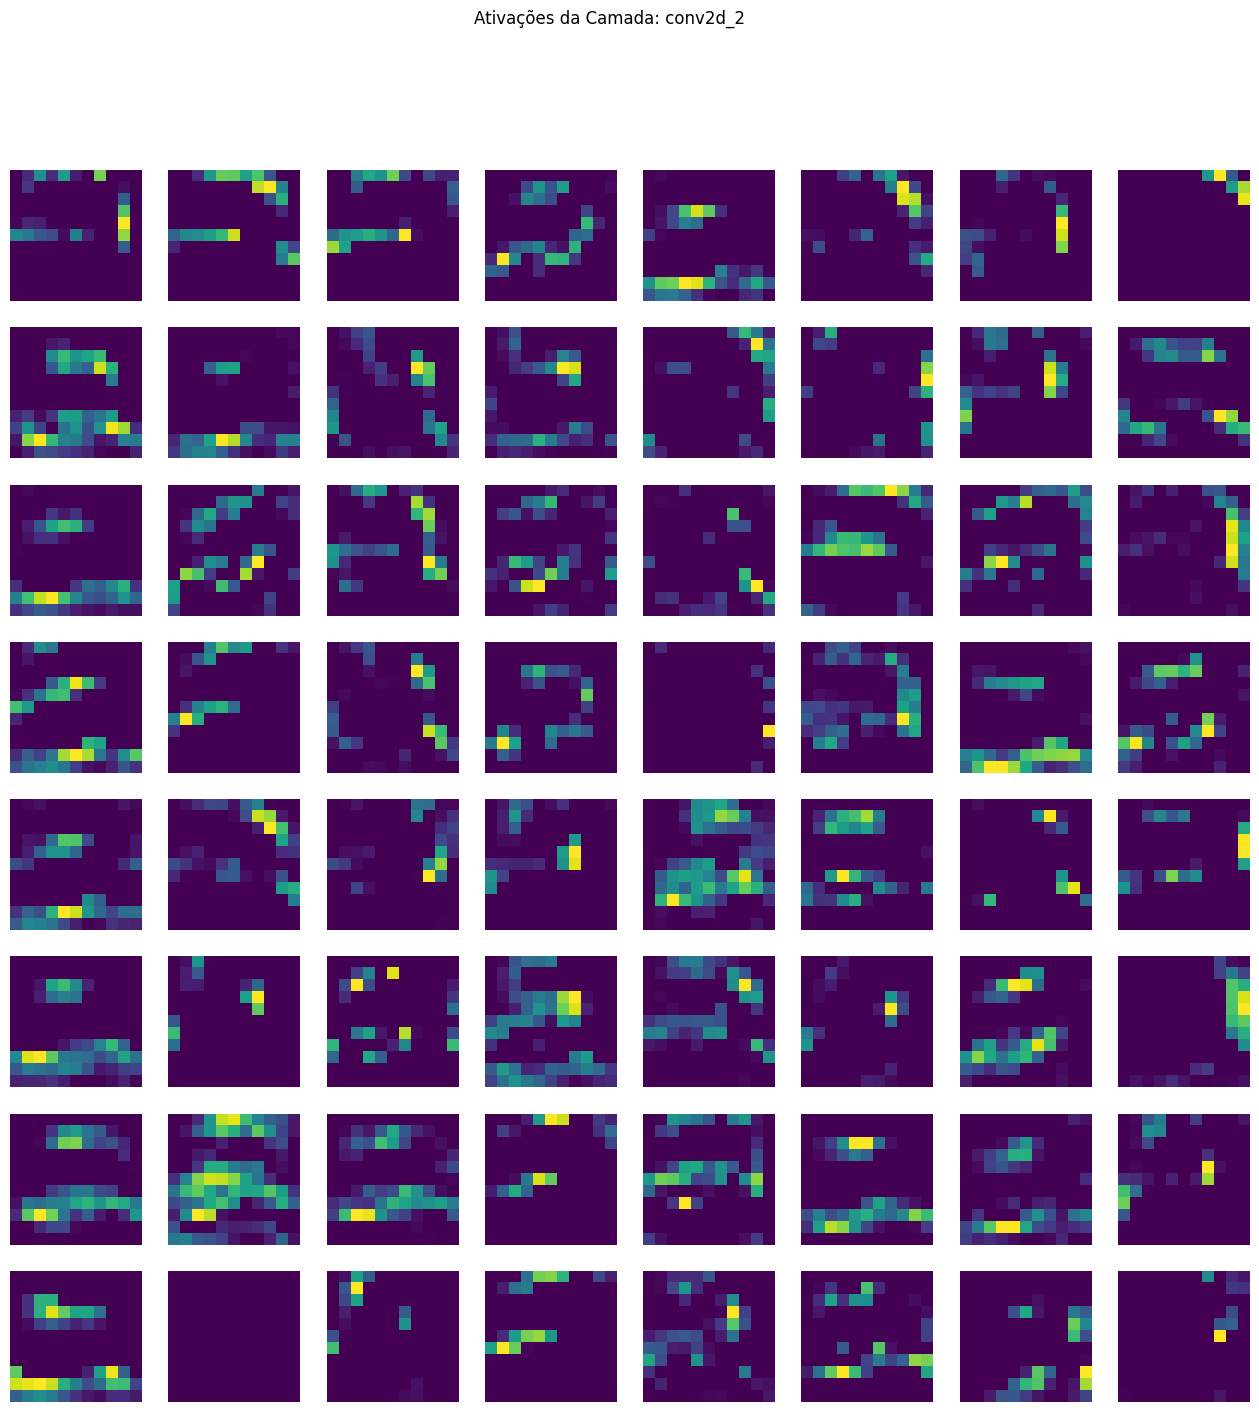

Visualizando ativações da camada: maxpooling2d_2
Formato da ativação: (1, 5, 5, 64)


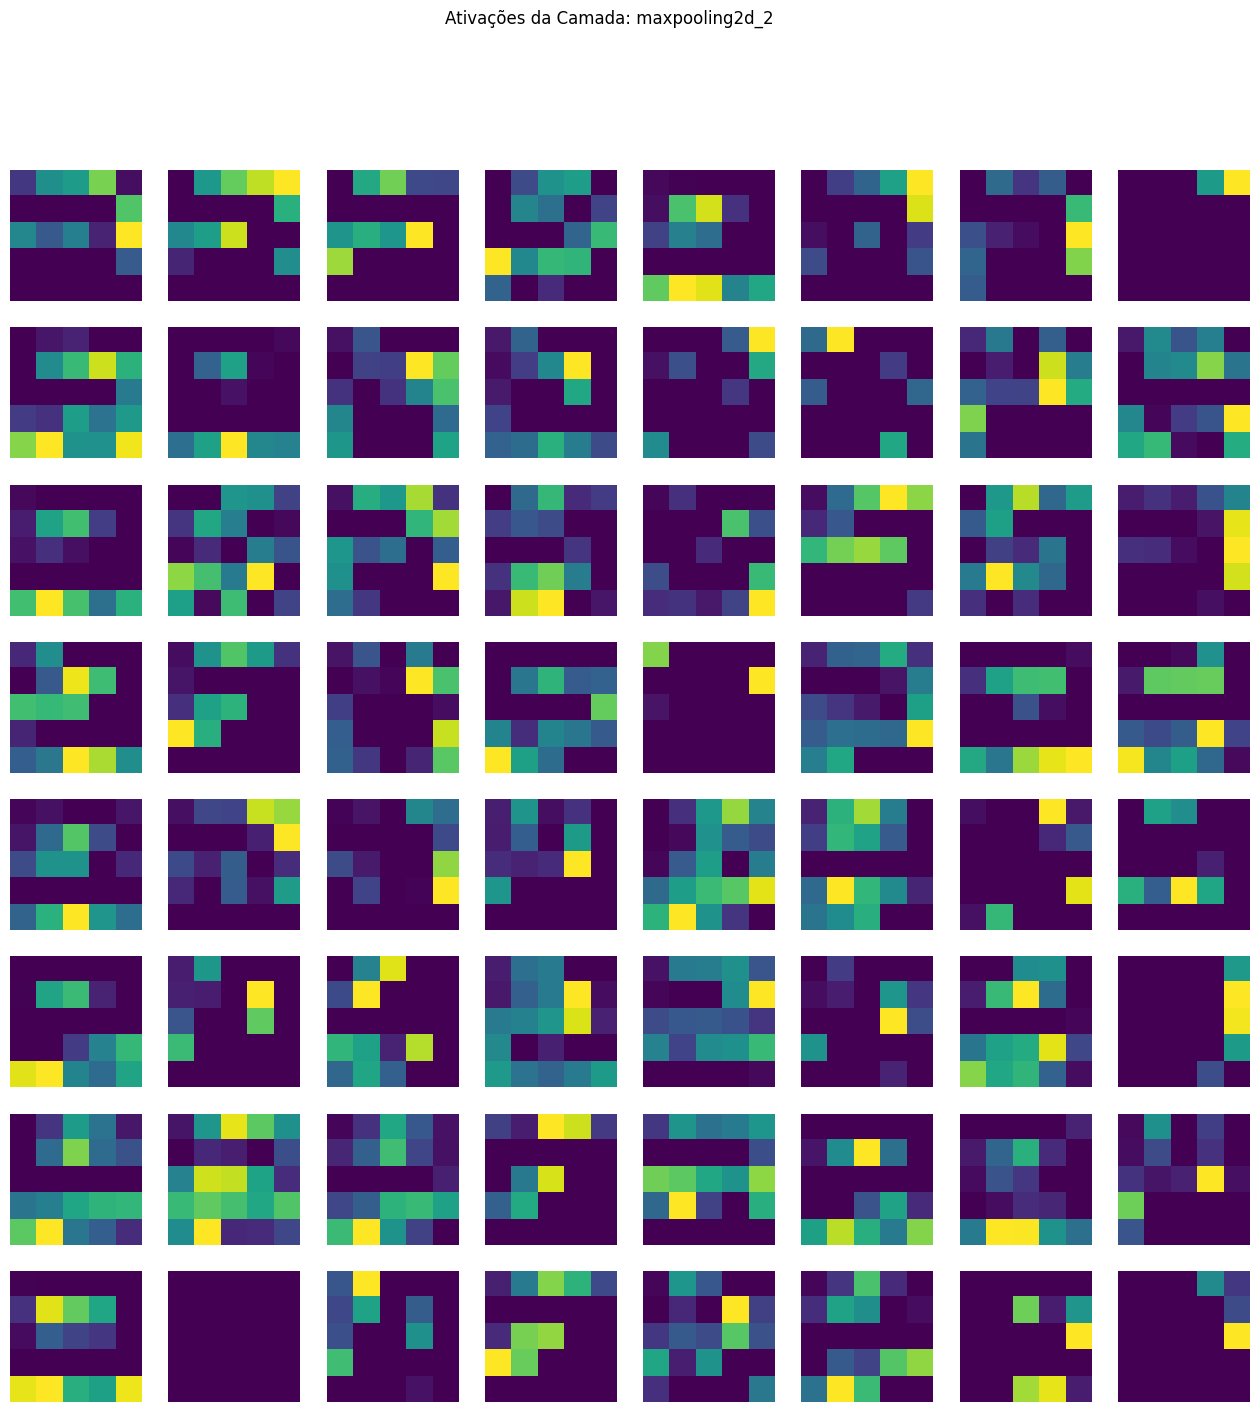

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Passo 1: Carregar o modelo e os pesos salvos
model = Sequential()

# Reconstruir a arquitetura do modelo com camadas nomeadas
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), name='conv2d_1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpooling2d_1'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpooling2d_2'))
model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', name='dense_1'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(10, activation='softmax', name='output'))

# Carregar os pesos salvos
model.load_weights('best_weights.h5')

# Compilar o modelo (isso inicializa o modelo)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Passo 2: Criar o modelo de ativação
# Extrair as saídas das camadas convolucionais e de pooling
layer_outputs = [layer.output for layer in model.layers[:4]]  # Pegar as saídas das primeiras 4 camadas
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Passo 3: Carregar uma imagem de exemplo (do new_data.csv)
new_data = pd.read_csv('new_data.csv')
image = new_data.iloc[0].values  # Pegar a primeira imagem
image = image.reshape(1, 28, 28, 1)  # Reshape para o formato (1, 28, 28, 1)

# Passo 4: Obter as ativações
activations = activation_model.predict(image)

# Passo 5: Visualizar as ativações
def display_activation(activations, layer_index, cols=8):
    """
    Função para exibir as ativações de uma camada específica.
    """
    activation = activations[layer_index]
    print(f"Formato da ativação: {activation.shape}")
    
    # Número de filtros na camada
    num_filters = activation.shape[-1]
    rows = num_filters // cols  # Número de linhas no grid
    
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
    for row in range(rows):
        for col in range(cols):
            filter_index = row * cols + col
            if filter_index < num_filters:  # Verificar se o índice do filtro é válido
                axs[row, col].imshow(activation[0, :, :, filter_index], cmap='viridis')
            axs[row, col].axis('off')
    
    plt.suptitle(f'Ativações da Camada: {model.layers[layer_index].name}')
    plt.show()

# Exibir as ativações de cada camada
for i, activation in enumerate(activations):
    layer_name = model.layers[i].name
    print(f"Visualizando ativações da camada: {layer_name}")
    display_activation(activations, i)